## Solving the Huggett Model (``Manually'')

The problem we saw in the first week of lecture simplified Aiyagari in the following way:


$$ \begin{array}{c}
\max_{\{c_t,a_t\}} \mathbb{E}_{0}\left[\sum_{t=0}^{\infty} \beta^{t} u\left(c_{t}\right)\right] \\
c_{t}+a_{t} \leq\left(1+r_{t-1}\right) a_{t-1}+s_{t} Y_{t} \\
a_{t} \geq \underline{a}
\end{array} $$

with idiosyncratic productivity following

$$ \log s_{t}=\rho \log s_{t-1}+\epsilon_{t} $$

where $\rho$ is the persistence and $\epsilon_t \sim \mathcal{N}(0,\sigma^2_\epsilon)$.

1. $\textbf{Recursive Formulation.}$ The Bellman equation for any household optimization problem is

$$ V_{t}\left(s_{t}, a_{t-1}\right)=\max _{a_{t} \geq \underline{a}}\left\{u\left(c_{t}\right)+\beta \mathbb{E}\left[V_{t+1}\left(s_{t+1}, a_{t}\right) \mid s_{t}\right]\right\}  $$

where $c_{t}=\left(1+r_{t-1}\right) a_{t-1}-a_{t}+s_{t} Y_{t}$. Note that the value function is time-dependent due to aggregate state variables: $\mathbf{X}_t\equiv (\{r_{s-1},Y_s\}_{s\geq t})$. Thus, using $\mathbf{x}_t\equiv (s_t,a_{t-1})$, we can write

$$ V\left(\mathbf{x}_t; \mathbf{X}_t \right)=\max _{a_{t} \geq \underline{a}}\left\{u\left[ (1+r_{t-1}) a_{t-1}-a_{t}+s_{t} Y_{t} \right]+\beta \mathbb{E}\left[V\left( s_{t+1}, a_{t}; \mathbf{X}_{t+1} \right) \mid s_{t}\right]\right\} $$

2. $\textbf{Optimality Conditions.}$ The FOC and envelope condition are, respectively,

$$ \partial u(c_t) \geq \beta \mathbb{E} [ \partial_a V\left( s_{t+1}, a_{t}; \mathbf{X}_{t+1} \right)  \mid s_{t} ] \text{ with equality if } a_t>\underline{a} $$

$$  \partial_a V\left( s_{t}, a_{t-1}; \mathbf{X}_{t} \right)  =  (1+r_{t-1})\partial u(c_t) $$

where $c_{t}=\left(1+r_{t-1}\right) a_{t-1}-a_{t}+s_{t} Y_{t}$.

3. $\textbf{Steady State.}$ At the steady state equilibrium, we have $r_t=r_{t-1}=r$ and $Y_{t+1}=Y_t=Y$ for all $t$. Then, the Bellman equation can be rewritten as

$$ V\left(s_{t}, a_{t-1}; r, Y\right)=\max _{a_{t} \geq \underline{a}}\left\{u\left[ (1+r)a_{t-1} - a_t  + s_t Y \right]+\beta \mathbb{E}\left[V\left(s_{t+1}, a_{t}; r, Y \right) \mid s_{t}\right]\right\}.  $$


In [1]:
import numpy as np 
import scipy.optimize as op
import scipy.interpolate as ip
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit, jit

plt.rc('font', size=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)  

# Parametrization
β      = 1-0.02
u      = lambda c: np.log(c)
du     = lambda c: c**-1
du_inv = lambda c: c**-1

# For Partial Equilibrium
Y      = 1 
r      = 0.01/4

# Idiosyncratic productivity
ρ     = 0.975
σ_s   = 0.7
σ_e   = σ_s*np.sqrt(1-ρ**2)

4. $\textbf{The Grid.}$ Discretizing the state-space $S \times A$. To induce a standard deviation of 0.7 for $\log s_t$, we need to set

$$ \sigma_e = \sigma_{\log s} \times \sqrt{ 1 - \rho^2}$$

In [2]:
# Asset discretization parameters
amin           = -1;
amax           = 200;
na             = 500;

# Productivity discretization parameters
ns             = 7;

# Iterations parameter
backward_tol   = 1e-8;
backward_maxit = 5000;
forward_tol    = 1e-10;
forward_maxit  = 5000;
shooting_tol   = 2e-4;
shooting_maxit = 5000;

# Discretization of s
MC     = qe.markov.approximation.rouwenhorst(ns, 0, σ_e, ρ);
s_grid = np.exp(np.asarray(MC._state_values)); 
Π      = MC.P;
π      = MC.stationary_distributions.T;
s_grid = s_grid /( s_grid @ π );

# Discretization of a
a_grid       = np.exp( np.linspace(np.log( 1e-1 ), np.log( amax - amin + 1e-1 ), num = na) )  + amin - 1e-1;

# Meshgrid and disposable income
ma_grid, ms_grid = np.meshgrid(a_grid,s_grid) 
R                = (1+r) * ma_grid + ms_grid*Y

# Collection all parameters
param = {'u': u, 'du': du, 'du_inv': du_inv, 'amin' : amin, 'amax': amax, 'na': na,
         'ns': ns, 'ρ': ρ, 'σ_e': σ_e, 'β': β, 'backward_tol': backward_tol, 
         'backward_maxit': backward_maxit, 'forward_tol': forward_tol , 'forward_maxit': forward_maxit, 
         'shooting_tol': shooting_tol, 'shooting_maxit': shooting_maxit, 'a_grid': a_grid, 's_grid': s_grid, 
         'ma_grid': ma_grid, 'ms_grid': ms_grid, 'π': π, 'Π': Π};

print('Ad hoc borrowing limit               = ', amin)
print('Natural borrowing limit              = ', - s_grid[0]*Y/r)
print('Minimum cash-on-hand (w/o borrowing) = ', min( R.flatten() ) )

Ad hoc borrowing limit               =  -1
Natural borrowing limit              =  -56.54775942218022
Minimum cash-on-hand (w/o borrowing) =  -0.8611306014445494


5. $\textbf{Backward Iteration.}$ Writing a (one-step) backward iteration function using Endogenous Gridt-point Method.

In [3]:
def households_EGM( dV_1 , X , parameters ):

    R0     = ( 1 + X[0] ) * parameters['ma_grid'] + parameters['ms_grid'] * X[1];
    
    # Discounting and expectations
    temp1  = parameters['β'] * ( parameters['Π'] @ dV_1 );

    # FOCs
    c_next = parameters['du_inv']( temp1 ); 
    a_0    = np.zeros_like( c_next );

    # Interpolating and policy functions
    for i in range(parameters['ns']):
        a_0[i,:] = ip.interp1d(c_next[i,:]+parameters['a_grid'],parameters['a_grid'],fill_value='extrapolate')(R0[i,:]);
        
    a_0  = np.maximum( a_0 , param['amin']);
    c_0  = R0 - a_0;
    dV_0 = ( 1 + X[0] )*parameters['du'](c_0);
    
    return dV_0, a_0, c_0   

6. $\textbf{Policy Functions}.$ Finding steady-state policies and plotting them. Savings function are characterized by each type having a 'buffer stock' level of assets.

TOC: Elapsed: 0:00:0.22


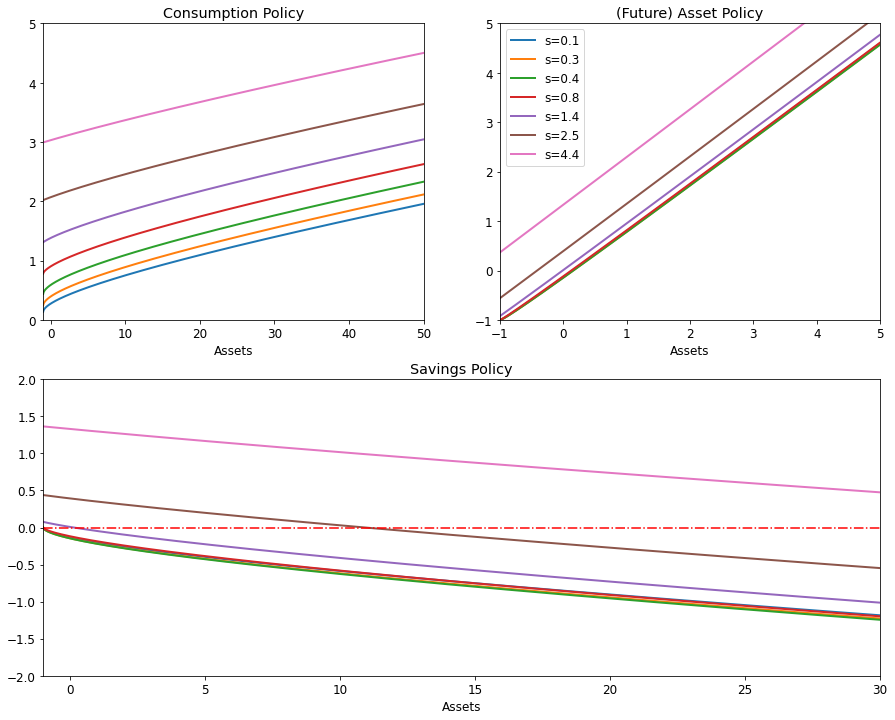

In [4]:
def SS_policies( dV_0 , X , parameters ):    
    ite  = 1;
    err  = 1;    
    while  err>parameters['backward_tol'] and ite<=parameters['backward_maxit'] :
        dV_1 , a_pol, c_pol = households_EGM( dV_0, X , parameters )
        err  = np.max(np.abs(dV_1 - dV_0) );
        ite += 1
        dV_0 = dV_1;     
    return dV_1, a_pol, c_pol   

# Solving the partial equilibrium
dV_guess         = (1+r) * param['du'](0.05*R);   
qe.tic()
dV, a_pol, c_pol = SS_policies( dV_guess ,  [r,Y], param )
time1            = qe.toc()

# Plots
fig, axes = plt.subplot_mosaic( [ ['a','b'], ['c', 'c'] ] , figsize=(15, 12))

for s, ys in enumerate( s_grid ):
    axes['a'].plot(a_grid, c_pol[s, :], label=f's={round(ys,1)}', linewidth=2 )
axes['a'].set( xlabel = 'Assets' , title = 'Consumption Policy' , ylim = (0,5) ,  xlim = (amin,50))

for s, ys in enumerate( s_grid ):
    axes['b'].plot(a_grid, a_pol[s, :], label=f's={round(ys,1)}' , linewidth=2 )
axes['b'].legend()
axes['b'].set( xlabel = 'Assets' , title = '(Future) Asset Policy' , ylim = (amin,5) , xlim = (amin,5) )

for s, ys in enumerate( s_grid ):
    axes['c'].plot(a_grid, a_pol[s, :] - a_grid, label=f's={round(ys,1)}', linewidth=2 )
axes['c'].plot(a_grid,np.zeros_like(a_grid),'r-.')    
axes['c'].set( xlabel = 'Assets' , title = 'Savings Policy' , ylim = (-2,2) , xlim = (amin,30) )

plt.show()

7. $\textbf{Forward Iteration.}$ Creating a function to perform a (one step) forward iteration using Young's histogram method. I use decorator @njit to vectorize the loops (without this, the code takes too much time to run). 

In [5]:
@njit  # vectorized loops
def forward_h( D0 , Π_T , aux, a_pi ):    
    ns, na = D0.shape;
    D1     = np.zeros_like( D0 )    
    for i in range(ns):
        for j in range(na):
            D1[i,aux[i,j]]   += a_pi[i,j]*D0[i,j]            
            D1[i,aux[i,j]+1] += (1-a_pi[i,j])*D0[i,j]  
    return Π_T @ D1

8. $\textbf{Stationary Distribution and Aggregation.}$ Applying forward iteration to compute a (partial equilibrium) steady state.

TOC: Elapsed: 0:00:0.69
 Aggregate Asset        =  0.68
 Aggregate Consumption  =  1.0
 % Constrained Agents   =  49.0


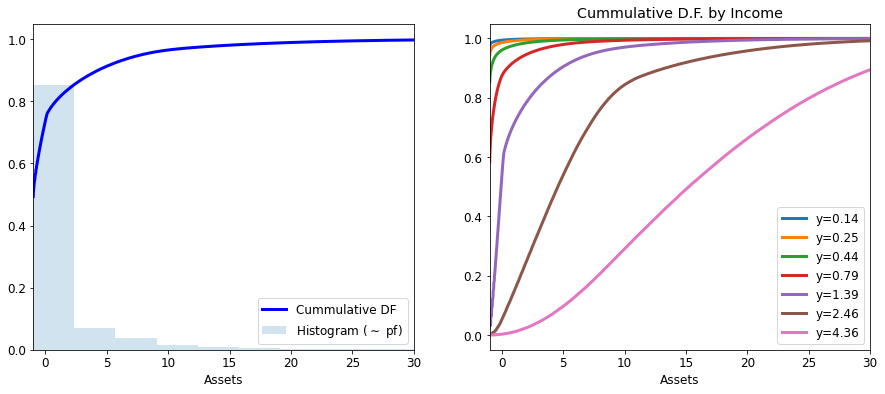

In [6]:
def SS_distribution( D0 , a_pol , parameters ):    
    Π_T  = parameters['Π'].T
    a_   = parameters['a_grid']    
    ite  = 1
    err  = 1
    
    # Get lottery first
    aux  = np.searchsorted( a_ , a_pol) - 1
    a_pi = (a_[aux+1] - a_pol)/(a_[aux+1] - a_[aux])    
    
    while  err>parameters['forward_tol'] and ite<=parameters['forward_maxit']:
        D1     = forward_h( D0 , Π_T , aux , a_pi )
        err    = np.max( np.abs(D1 - D0) )
        ite   += 1
        D0     = D1     
    return D1

# Solving the stationary distribution
D_guess = π * np.ones_like(a_grid) / len(a_grid)

qe.tic()
D_ss    = SS_distribution( D_guess , a_pol , param  )
time2   = qe.toc()

d_ss    = D_ss.sum(axis=0);
A_ss    = np.sum( a_pol * D_ss );
C_ss    = np.sum( c_pol * D_ss );

print(' Aggregate Asset        = ', round(A_ss,2) )
print(' Aggregate Consumption  = ', round(C_ss,2) )
print(' % Constrained Agents   = ', 100* round( d_ss[0] , 2 ) )

# Plots
fig, axes = plt.subplots( 1 , 2 , figsize=(15, 6))

axes[0].hist(a_grid, weights = d_ss , bins = 60 , alpha = 0.2, label='Histogram ($\sim$ pf)');     
axes[0].plot(a_grid, d_ss.cumsum(), 'b', linewidth=3 , label='Cummulative DF');
axes[0].legend();
axes[0].set( xlabel='Assets', xlim=(amin,30));

for s, y in enumerate(s_grid):
    axes[1].plot(a_grid, D_ss[s].cumsum()/π[s], label=f'y={y:.2f}', linewidth=3 )
axes[1].legend();
axes[1].set( xlabel='Assets' , title = 'Cummulative D.F. by Income' , xlim=(amin,30) );
plt.show()

9. $\textbf{Aggregate Savings Supply and Consumption.}$ Unsurprisingly, the graphs below indicate that when interest rates are too low, the aggregate supply of assets is close to the borrowing constraint. On the other hand, if the interest rate is close too $1/\beta-1$, the aggregate supply of assets increases unboundedly.

TOC: Elapsed: 0:00:3.22


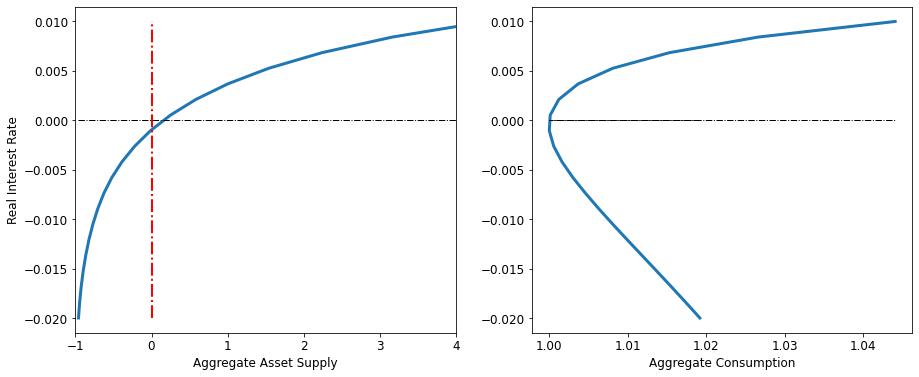

In [7]:
r_grid = np.linspace( -0.02, 0.010 , num = 20) # If you want to increase the upper bound, should increase a_max as well
A_ss_r = np.zeros_like( r_grid );
C_ss_r = np.zeros_like( r_grid );

qe.tic()
for i in range(len(r_grid)):
    dV_, a_pol_, c_pol_ = SS_policies( dV ,  [r_grid[i], Y ] , param );
    D_ss_               = SS_distribution( D_ss , a_pol_ , param  );
    A_ss_r[i]           = np.sum( a_pol_ * D_ss_ );
    C_ss_r[i]           = np.sum( c_pol_ * D_ss_ );    
time3 = qe.toc()

# Plots
fig, axes = plt.subplots( 1 , 2 , figsize=(15, 6))

axes[0].plot(  A_ss_r , r_grid , linewidth=3 )
axes[0].plot(  np.zeros_like(A_ss_r) , r_grid , 'r-.' , linewidth=2 )
axes[0].plot(  A_ss_r , np.zeros_like(A_ss_r) , 'k-.' , linewidth=1 )
axes[0].set(xlabel='Aggregate Asset Supply', ylabel='Real Interest Rate', xlim=(amin,4) )

axes[1].plot( C_ss_r , r_grid , linewidth=3 )
axes[1].plot( C_ss_r , np.zeros_like(C_ss_r) , 'k-.' , linewidth=1 )
axes[1].set( xlabel = 'Aggregate Consumption' )

plt.show()

10. $\textbf{General Equilibrium Steady State.}$ Finding roots via Brent's method. The code takes 20 seconds to compute the steady-state equilibrium. Note that if the real interest rate of equilibrium $r_{ss}$ is close to zero, the market clearing condition can lead to numerical problems when computing $r_{ss}$. The reason for this is that $C=Y$ implies $A=0$ only when $r_{ss}\neq 0$. Numerically this can imply problems.

TOC: Elapsed: 0:00:2.59
General Equilibrium Interest Rate =  -0.3846102403945472 % (Annual)
 Aggregate Asset        =  -0.0
 Aggregate Consumption  =  1.0
 % Constrained Agents   =  55.00000000000001


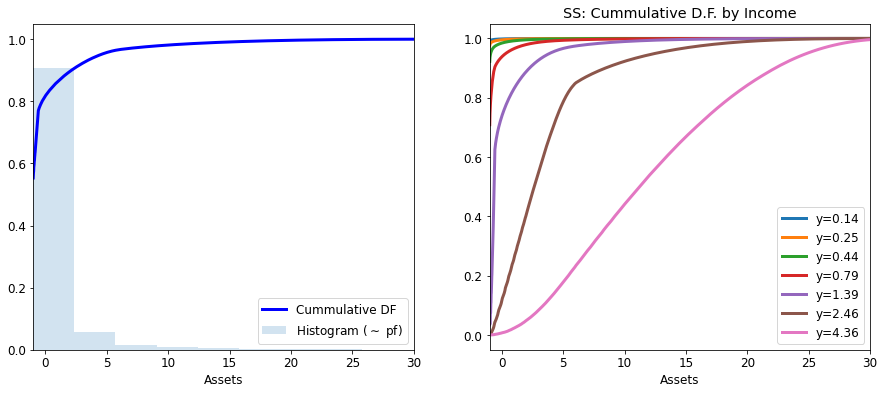

In [8]:
def ExA_ss( r_ss , Y_ss, parameters ):
    R_ss        = ( 1 + r_ss ) * parameters['ma_grid'] + parameters['ms_grid']*Y_ss;
    dV_         = ( 1 + r_ss ) * parameters['du']( 0.05*R_ss ); 
    D_ss_       = np.ones( [parameters['ns'] , parameters['na']]) / (parameters['ns'] * parameters['na'] ); 
    dV_, a_, c_ = SS_policies( dV_ ,  [r_ss,Y_ss] , param );
    D_ss_       = SS_distribution( D_ss_ , a_ , param );
    A_ss_       = np.sum( a_ * D_ss_ );      
    return A_ss_

rmax      = 0.01;
rmin      = -0.02;

fobj      = lambda x: ExA_ss(x, Y, param);

qe.tic()
r_ss                      = op.brentq(fobj, rmin, rmax);    
dV_ss, a_pol_ss, c_pol_ss = SS_policies( dV ,  [r_ss, Y ] , param );
D_ss                      = SS_distribution( D_ss , a_pol_ss , param  );  
time4                     = qe.toc()

d_ss                      = D_ss.sum(axis=0);
A_ss                      = np.sum( a_pol_ss * D_ss );
C_ss                      = np.sum( c_pol_ss * D_ss );
Y_ss                      = Y;
SS                        = { 'dV_ss': dV_ss, 'a_pol_ss': a_pol_ss, 'c_pol_ss': c_pol_ss, 'd_ss': d_ss, 
                              'D_ss': D_ss, 'r_ss': r_ss, 'Y_ss': Y_ss, 'C_ss': C_ss, 'A_ss': A_ss };

print('General Equilibrium Interest Rate = ', 100*4*r_ss, '% (Annual)')    

print(' Aggregate Asset        = ', round(A_ss,2) )
print(' Aggregate Consumption  = ', round(C_ss,2) )
print(' % Constrained Agents   = ', 100* round( d_ss[0] , 2 ) )

# Plots
fig, axes = plt.subplots( 1 , 2 , figsize=(15, 6))

axes[0].hist(a_grid, weights = d_ss , bins = 60 , alpha = 0.2, label='Histogram ($\sim$ pf)');     
axes[0].plot(a_grid, d_ss.cumsum(), 'b', linewidth=3 , label='Cummulative DF');
axes[0].legend();
axes[0].set( xlabel='Assets', xlim=(amin,30));

for s, y in enumerate(s_grid):
    axes[1].plot(a_grid, D_ss[s].cumsum()/π[s], label=f'y={y:.2f}', linewidth=3 )
axes[1].legend();
axes[1].set( xlabel='Assets' , title = 'SS: Cummulative D.F. by Income' , xlim=(amin,30) );
plt.show()

11. $\textbf{General Equilibrium Transition Dynamics.}$ Consider a perturbation on the aggregate productivity

$$ Y_t = Y + dY\times \eta^t \; \text{ for } t\geq 0. $$

The code takes less than 4 minutes to compute the transition dynamics ($T=300$ periods and 3e-3 as tolerance criterion).

In [9]:
def shooting_algorithm( T , η , dY , SS , κ , parameters ):
    
    Π_T     = parameters['Π'].T
    a_grid  = parameters['a_grid']
    err_tol = parameters['shooting_tol']
    maxit   = parameters['shooting_maxit']    
    c_t     = np.empty( [ns,na,T] )
    a_t     = np.empty( [ns,na,T] )
    D_t     = np.empty( [na,T] )
    C_t     = np.empty( T )
    A_t     = np.empty( T )
    Y_t     = SS['Y_ss'] + dY * η**( np.arange(T) )
    r_t     = np.zeros(T+1) + SS['r_ss']        
    ite     = 1;
    err     = 1;
    
    while err>err_tol and ite<=maxit:
        
        dV      = SS['dV_ss'] * (1+r_t[-1])/(1+SS['r_ss'])
        D       = SS['D_ss']       
        
        for t in range(1,T+1):
            dV , a_t[:,:,-t], c_t[:,:,-t] = households_EGM( dV, [r_t[-t-1], Y_t[-t]] , param ) 

        for t in range(T):
            C_t[t]      = np.sum( c_t[:,:,t] * D )
            A_t[t]      = np.sum( a_t[:,:,t] * D )   
            D_t[:,t]    = D.sum(axis=0)
            aux         = np.searchsorted( a_grid , a_t[:,:,t]) - 1
            a_pi        = (a_grid[aux+1] - a_t[:,:,t] )/(a_grid[aux+1] - a_grid[aux])              
            D           = forward_h( D , Π_T , aux , a_pi )     
        
        err = np.max( np.abs( A_t ) )
        r_t[1:] = r_t[1:] - κ*A_t
    r_t = r_t[0:T]      
    
    return {'r_t': r_t, 'C_t': C_t, 'A_t': A_t, 'D_t': D_t, 'Y_t': Y_t}
            
dY      = 0.01;
η       = 0.90;
T       = 100;
κ       = 0.01;

qe.tic()
MIT     = shooting_algorithm(T , η , dY , SS , κ , param);
time5   = qe.toc() 

TOC: Elapsed: 0:00:37.52


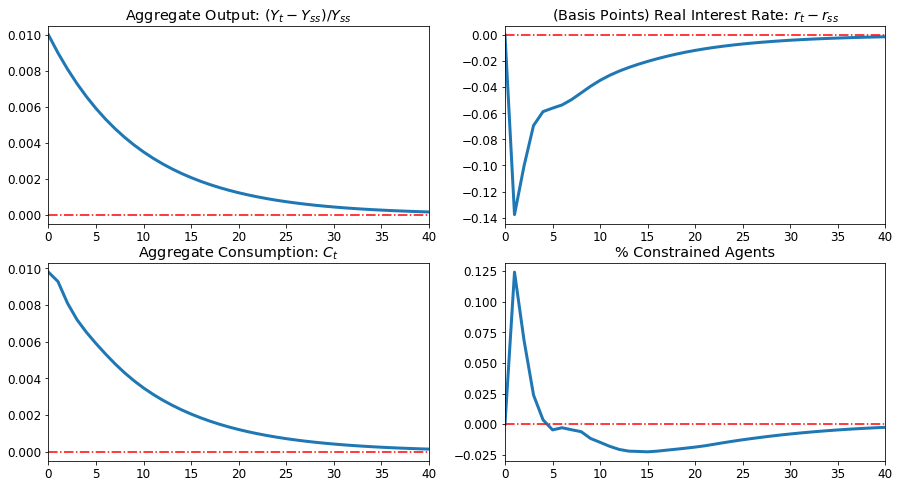

[Text(0.5, 0.92, 'Cummulative Distribution of Assets')]

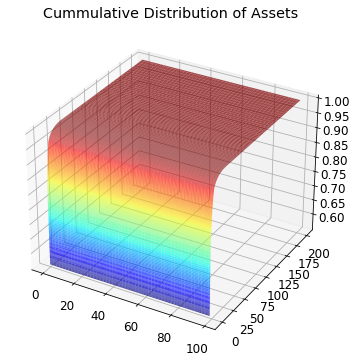

In [12]:
time         = np.arange(T);
ConstFrac    = 100*MIT['D_t'][0,:];
ConstFrac_ss = 100*MIT['D_t'][0,-1];

fig, axes = plt.subplots( 2 , 2 , figsize=(15, 8))

axes[0,0].plot( time , (MIT['Y_t'] - SS['Y_ss'])/SS['Y_ss'] , linewidth=3 )
axes[0,0].plot( time , np.zeros( T ) , 'r-.' )
axes[0,0].set( title = 'Aggregate Output: $(Y_t - Y_{ss})/Y_{ss}$' , xlim=(0,40));

axes[0,1].plot( time , 100*(MIT['r_t'] - SS['r_ss']) , linewidth=3 )
axes[0,1].plot( time , np.zeros( T ) , 'r-.' )
axes[0,1].set( title = '(Basis Points) Real Interest Rate: $r_t - r_{ss}$' , xlim=(0,40));

axes[1,0].plot( time , (MIT['C_t'] - SS['C_ss'])/SS['C_ss'] , linewidth=3 )
axes[1,0].plot( time , np.zeros( T ) , 'r-.' )
axes[1,0].set( title = 'Aggregate Consumption: $C_t$' , xlim=(0,40));

axes[1,1].plot( time , ConstFrac - ConstFrac_ss, linewidth=3 )
axes[1,1].plot( time , np.zeros( T ) , 'r-.' )
axes[1,1].set( title = '% Constrained Agents', xlim=(0,40));

plt.show()

ma_grid_, mt_grid_ = np.meshgrid( time, a_grid);
fig                = plt.figure(figsize=(10, 6))
ax                 = fig.add_subplot(111, projection='3d')
ax.plot_surface(ma_grid_ , mt_grid_ , MIT['D_t'].cumsum(axis=0) , rstride=2 , cstride=2,
                cmap=plt.cm.jet , alpha=0.7 , linewidth=0.25 )
ax.set( title = 'Cummulative Distribution of Assets' )